In [9]:
import ecc_tools as tools
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
from direct_info import direct_info
from direct_info import distance_restr

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

# import pydca for plmDCA
from pydca.plmdca import plmdca
from pydca.meanfield_dca import meanfield_dca
from pydca.sequence_backmapper import sequence_backmapper
from pydca.msa_trimmer import msa_trimmer
from pydca.contact_visualizer import contact_visualizer
from pydca.dca_utilities import dca_utilities

tools.hide_toggle()

## Using comprehensive software package for DCA
#### Author: Mehari B. Zerihun
article: https://academic.oup.com/bioinformatics/advance-article/doi/10.1093/bioinformatics/btz892/5645176
github: https://github.com/KIT-MBS/pydca
* mean field and pseudoliklihood methos
* several utility functions
    * MSA triming functions
    * Contact Map Plotting Functions

In [2]:
pfam_id = 'PF00186'                                                              

rna_msa_file = '../pydca/examples/MSA_RF00167.fa'
rna_refseq_file = '../pydca/examples/ref_RF00167.fa'

# create MSATrimmer instance 
trimmer = msa_trimmer.MSATrimmer(
    rna_msa_file, biomolecule='rna', 
    refseq_file=rna_refseq_file,
)

trimmed_data = trimmer.get_msa_trimmed_by_refseq(remove_all_gaps=True)

In [3]:
# DCA scores using Pseudolikelihood maximization algorithm
#write trimmed msa to file in FASTA format
trimmed_data_outfile = 'MSA_RF00167_Trimmed.fa'
with open(trimmed_data_outfile, 'w') as fh:
    for seqid, seq in trimmed_data:
        fh.write('>{}\n{}\n'.format(seqid, seq))
        
plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'rna',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)

# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()

In the above, we have imported pydca or selected modules from pydca. Then we defined two variables rna_msa_file and rna_refseq_file that contain paths to an RNA MSA file and its reference sequence, respectively. Following that we created an MSATrimmer instance which enabled us to trim the MSA file. Finally, we write the trimmed MSA data to an output file MSA_RF00167_Trimmed.fa in FASTA format. To trim protein sequences we just need to change biomolecule='rna' to biomolecule='protein' and provide the respective MSA and reference sequence files. Next we carry out DCA computations using the trimmed MSA saved in MSA_RF00167_Trimmed.fa

### DCA Computation Using Pseudolikelihood Maximization Algorithm (plmDCA)

In [4]:
# Compute DCA scores using Pseudolikelihood maximization algorithm

plmdca_inst = plmdca.PlmDCA(
    trimmed_data_outfile,
    'rna',
    seqid = 0.8,
    lambda_h = 1.0,
    lambda_J = 20.0,
    num_threads = 10,
    max_iterations = 500,
)

# compute DCA scores summarized by Frobenius norm and average product corrected
plmdca_FN_APC = plmdca_inst.compute_sorted_FN_APC()

In the above, we created a PlmDCA instance plmdca_inst for RNA. Notice that we used the trimmed MSA data we obtained before. We also set the values of optional parameters. The optional parameters num_threads is set to 10. If pydca is installed without OpenMP support, we cannot set the number of threads more than one. Finally we computed the DCA scores from the Frobenius norm of the couplings by calling the compute_sorted_FN_APC() method on plmdca_inst. This action returns the average product corrected (APC) DCA scores. Let us print the top five site pairs and their DCA scores.

In [5]:
for site_pair, score in plmdca_FN_APC[:5]:
    print(site_pair, score)

(45, 55) 2.5677507089237
(44, 56) 2.5458142216370008
(16, 28) 2.526825408420917
(17, 27) 2.497935046886282
(43, 57) 2.4314314577951963


We have displayed the top five site pairs ranked by their DCA scores. The first column is a tuple of site-pairs and the second column contains the DCA scores obtained from the Frobenius norm of the couplings. Note that the site pairs are arranged in the form (i, j) such that j > i.

## Plotting Contact Map and True Positive Rates

Next we plot the contact map and true positive rates of DCA scores computed using the two methods (plmDCA and mfDCA)


In [6]:
plmdca_visualizer = contact_visualizer.DCAVisualizer('rna', 'x', '1y26',
    refseq_file = rna_refseq_file,
    sorted_dca_scores = plmdca_FN_APC,
    linear_dist = 4,
    contact_dist = 8.0,
)


	You didn't supply RNA secondary structure file.


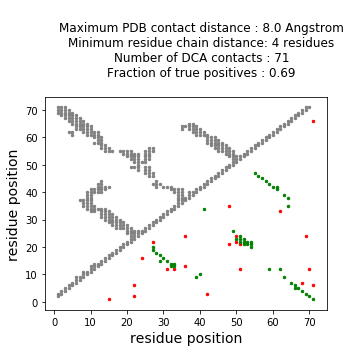

In [7]:
contact_map_data = plmdca_visualizer.plot_contact_map()

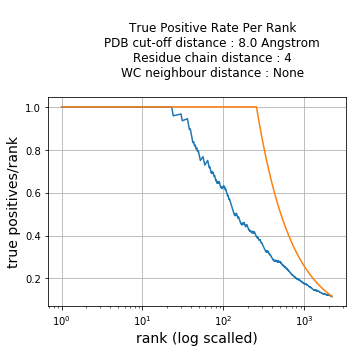

In [8]:
tp_rate_data = plmdca_visualizer.plot_true_positive_rates()